<a href="https://colab.research.google.com/github/t-tsue/public/blob/main/PBL02_sample_swin_v2_b_bin2_ep50_special.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
DIR='/content/drive/My Drive/DXQuest_PBL02/'

Mounted at /content/drive


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

train_files = glob.glob(os.path.join(DIR,'train', '*/*.jpeg'))
test_files = sorted(glob.glob(os.path.join(DIR,'test', '*.jpeg')))

train_df = pd.DataFrame(train_files, columns=['file_name'])
test_df = pd.DataFrame(test_files, columns=['file_name'])

In [3]:
def get_label(x):
  # (regular → horn)
  # regular_008.jpeg
  #if 'regular_008' in x:
  #  return 1

  # (horn → regular)
  # horn_016.jpeg
  #if 'horn_016' in x:
  #  return 0

  #(potato → regular)
  # potato_037.jpeg
  #if 'potato_037' in x:
  #  return 0

  if 'bridge' in x:
    return 1
  elif 'horn' in x:
    return 1
  elif 'potato' in x:
    return 1
  else:
    return 0

train_df['label'] = train_df['file_name'].apply(get_label)

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import random
import torch.utils.data as data
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

In [6]:
SIZE = 272
CSIZE = 256
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

class ImageTransform():
  def __init__(self, phase, resize = SIZE, csize=CSIZE, mean = MEAN, std = STD):
    self.phase = phase
    if phase == 'train':
      self.data_transform = transforms.Compose([
          transforms.RandomResizedCrop(csize,scale=(0.9,1)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(degrees=(-10,10)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
    else:
      self.data_transform = transforms.Compose([
          transforms.Resize(resize),
          transforms.CenterCrop(csize),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])

  def __call__(self, img):
    return self.data_transform(img)

In [7]:
class CustomDataset(Dataset):
  def __init__(self, df, phase='train'):
    self.df = df
    self.transform = ImageTransform(phase)
    self.phase = phase

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if self.phase != 'test':
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      label = self.df.iloc[index]['label']
      return img_transformed, label
    else:
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      return img_transformed


In [8]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs, iter):
  best_loss = 99
  best_acc = 0
  scores=[]
  net.to(device)
  # epochのループ
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()  # モデルを訓練モードに
      else:
        net.eval()   # モデルを検証モードに

      # epochごとの学習と検証のループ

      epoch_loss = 0.0  # epochの損失和
      epoch_corrects = 0  # epochの正解数


      # データローダーからミニバッチを取り出すループ
      dataloader = dataloader_dict[phase]
      for inputs, labels in tqdm(dataloader):

        # optimizerを初期化
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase=='train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)  # 損失を計算
          _, preds = torch.max(outputs, 1)  # ラベルを予測


          # 訓練時はバックプロパゲーション
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # イタレーション結果の計算
          # lossの合計を更新
          epoch_loss += loss.item() * inputs.size(0)
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

      # epochごとのlossと正解率を表示
      epoch_loss = epoch_loss / len(dataloader.dataset)
      epoch_acc = epoch_corrects.double(
      ) / len(dataloader.dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      if phase == 'val':
        if epoch_loss <= best_loss:
          best_loss = epoch_loss
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{EPOCHS}_{iter}_best_loss_bin2.pth'))
          net.to(device)
        if epoch_acc >= best_acc:
          best_acc = epoch_acc
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{EPOCHS}_{iter}_best_acc_bin2.pth'))
          net.to(device)
      scores.append([iter, epoch, phase, epoch_loss, epoch_acc])
  return net, pd.DataFrame(scores, columns=['iter', 'epoch', 'phase', 'loss', 'acc'])

In [9]:
BATCH_SIZE = 60
EPOCHS = 50
LEARNING_RATE = 0.001
#MOMENTUM = 0.9

def get_model():
  weights = models.Swin_V2_B_Weights.IMAGENET1K_V1  # 学習済みのパラメータを使用
  net = models.swin_v2_b(weights=weights)
  net.head = nn.Linear(in_features=1024, out_features=2, bias=True)
  return net

def get_criterion():
  criterion = nn.CrossEntropyLoss()
  return criterion

def get_optimizer(net):
  params_to_update = []

  update_param_names = ["head.weight",
                        "head.bias",
                        "norm.weight",
                        "norm.bias",
                        "features.7.1.mlp.3.weight",
                        "features.7.1.mlp.3.bias",
                        ]
  for name, param in net.named_parameters():
    if name in update_param_names:
      param.requires_grad = True
      params_to_update.append(param)
    else:
      param.requires_grad = False

  optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, )
  return optimizer

In [10]:
def predict(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  return np.argmax(np.array(result),axis=1)

def predict_proba(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  result = np.array(result)
  pred_0 = result[:,0]
  pred_1 = result[:,1]
  return np.exp(pred_1)/(np.exp(pred_0)+np.exp(pred_1))

def get_score(y_true, y_pred):
  y_true = (y_true > 0).astype(int)
  y_pred = (y_pred > 0).astype(int)
  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return [acc, recall, precision, f1]

SEED=42

def init_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
scores = pd.DataFrame()
for seed in range(1):
  seed = SEED + seed
  init_seed(seed)
  g = torch.Generator()
  g.manual_seed(seed)
  skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=seed)
  X = train_df
  y = train_df['label']
  MODEL_DIR=os.path.join(DIR,'model')
  os.makedirs(MODEL_DIR, exist_ok=True)
  for iter, (train_index, test_index) in enumerate(skf.split(X, y)):
    if iter == 0:
      continue
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    train_dataset = CustomDataset(X_train, phase='train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                    worker_init_fn=seed_worker,generator=g)
    val_dataset = CustomDataset(X_val, phase='val')
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    net = get_model()
    criterion = get_criterion()
    optimizer = get_optimizer(net)
    dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}
    net,score = train_model(net, dataloader_dict, criterion, optimizer, EPOCHS, iter)
    torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{EPOCHS}_{iter}_bin2.pth'))
    scores = pd.concat([scores, score])
    break

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:03<00:00, 105MB/s]


Epoch 1/50
-------------


100%|██████████| 5/5 [03:05<00:00, 37.19s/it]


train Loss: 0.7685 Acc: 0.6522


100%|██████████| 1/1 [00:27<00:00, 27.95s/it]


val Loss: 0.7128 Acc: 0.3784
Epoch 2/50
-------------


100%|██████████| 5/5 [00:42<00:00,  8.52s/it]


train Loss: 0.6792 Acc: 0.6047


100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


val Loss: 0.6484 Acc: 0.6486
Epoch 3/50
-------------


100%|██████████| 5/5 [00:40<00:00,  8.10s/it]


train Loss: 0.6717 Acc: 0.6561


100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


val Loss: 0.6490 Acc: 0.6486
Epoch 4/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.58s/it]


train Loss: 0.6126 Acc: 0.6680


100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


val Loss: 0.6033 Acc: 0.8108
Epoch 5/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


train Loss: 0.6352 Acc: 0.6561


100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


val Loss: 0.5806 Acc: 0.6486
Epoch 6/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.60s/it]


train Loss: 0.6200 Acc: 0.6601


100%|██████████| 1/1 [00:04<00:00,  4.92s/it]


val Loss: 0.6427 Acc: 0.6486
Epoch 7/50
-------------


100%|██████████| 5/5 [00:35<00:00,  7.20s/it]


train Loss: 0.6351 Acc: 0.6601


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


val Loss: 0.5704 Acc: 0.6486
Epoch 8/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


train Loss: 0.5743 Acc: 0.7273


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


val Loss: 0.5707 Acc: 0.8108
Epoch 9/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


train Loss: 0.5927 Acc: 0.7036


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


val Loss: 0.5525 Acc: 0.8108
Epoch 10/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


train Loss: 0.5630 Acc: 0.7075


100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


val Loss: 0.5652 Acc: 0.6486
Epoch 11/50
-------------


100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


train Loss: 0.5677 Acc: 0.6877


100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


val Loss: 0.5536 Acc: 0.6757
Epoch 12/50
-------------


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


train Loss: 0.5579 Acc: 0.7273


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


val Loss: 0.5351 Acc: 0.8108
Epoch 13/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


train Loss: 0.5396 Acc: 0.7194


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


val Loss: 0.5226 Acc: 0.8108
Epoch 14/50
-------------


100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


train Loss: 0.5377 Acc: 0.7273


100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


val Loss: 0.5340 Acc: 0.7838
Epoch 15/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.40s/it]


train Loss: 0.5339 Acc: 0.7510


100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


val Loss: 0.5199 Acc: 0.7838
Epoch 16/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


train Loss: 0.5345 Acc: 0.7510


100%|██████████| 1/1 [00:05<00:00,  5.47s/it]


val Loss: 0.4962 Acc: 0.8108
Epoch 17/50
-------------


100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


train Loss: 0.5440 Acc: 0.7470


100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


val Loss: 0.4770 Acc: 0.8108
Epoch 18/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.83s/it]


train Loss: 0.5396 Acc: 0.7470


100%|██████████| 1/1 [00:05<00:00,  5.79s/it]


val Loss: 0.4821 Acc: 0.8108
Epoch 19/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


train Loss: 0.5255 Acc: 0.7312


100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


val Loss: 0.4627 Acc: 0.8108
Epoch 20/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


train Loss: 0.4874 Acc: 0.7826


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


val Loss: 0.4924 Acc: 0.8108
Epoch 21/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.51s/it]


train Loss: 0.5374 Acc: 0.7154


100%|██████████| 1/1 [00:05<00:00,  5.96s/it]


val Loss: 0.4873 Acc: 0.8108
Epoch 22/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


train Loss: 0.5215 Acc: 0.7352


100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


val Loss: 0.4489 Acc: 0.8378
Epoch 23/50
-------------


100%|██████████| 5/5 [00:40<00:00,  8.06s/it]


train Loss: 0.5047 Acc: 0.7708


100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


val Loss: 0.4518 Acc: 0.8108
Epoch 24/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.57s/it]


train Loss: 0.4802 Acc: 0.7866


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


val Loss: 0.4229 Acc: 0.8378
Epoch 25/50
-------------


100%|██████████| 5/5 [00:40<00:00,  8.00s/it]


train Loss: 0.4688 Acc: 0.8063


100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


val Loss: 0.4141 Acc: 0.8108
Epoch 26/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


train Loss: 0.4794 Acc: 0.7708


100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


val Loss: 0.4033 Acc: 0.8108
Epoch 27/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


train Loss: 0.5041 Acc: 0.7549


100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


val Loss: 0.4079 Acc: 0.8108
Epoch 28/50
-------------


100%|██████████| 5/5 [00:36<00:00,  7.20s/it]


train Loss: 0.4542 Acc: 0.7905


100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


val Loss: 0.3846 Acc: 0.8649
Epoch 29/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


train Loss: 0.5068 Acc: 0.7510


100%|██████████| 1/1 [00:05<00:00,  5.33s/it]


val Loss: 0.3786 Acc: 0.8649
Epoch 30/50
-------------


100%|██████████| 5/5 [00:40<00:00,  8.11s/it]


train Loss: 0.4325 Acc: 0.7708


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


val Loss: 0.3722 Acc: 0.8649
Epoch 31/50
-------------


100%|██████████| 5/5 [00:40<00:00,  8.08s/it]


train Loss: 0.4822 Acc: 0.7747


100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


val Loss: 0.3581 Acc: 0.8919
Epoch 32/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


train Loss: 0.4766 Acc: 0.7668


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


val Loss: 0.3517 Acc: 0.8919
Epoch 33/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


train Loss: 0.5060 Acc: 0.7668


100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


val Loss: 0.3565 Acc: 0.8919
Epoch 34/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.73s/it]


train Loss: 0.4617 Acc: 0.7984


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


val Loss: 0.3991 Acc: 0.8919
Epoch 35/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


train Loss: 0.4408 Acc: 0.8142


100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


val Loss: 0.3847 Acc: 0.8378
Epoch 36/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


train Loss: 0.4376 Acc: 0.7945


100%|██████████| 1/1 [00:04<00:00,  4.55s/it]


val Loss: 0.3856 Acc: 0.8919
Epoch 37/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.75s/it]


train Loss: 0.4725 Acc: 0.7510


100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


val Loss: 0.3912 Acc: 0.9189
Epoch 38/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


train Loss: 0.5105 Acc: 0.7589


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


val Loss: 0.4142 Acc: 0.8378
Epoch 39/50
-------------


100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


train Loss: 0.4865 Acc: 0.7470


100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


val Loss: 0.3638 Acc: 0.8919
Epoch 40/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


train Loss: 0.4869 Acc: 0.7747


100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


val Loss: 0.3482 Acc: 0.8919
Epoch 41/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.74s/it]


train Loss: 0.4628 Acc: 0.7945


100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


val Loss: 0.3780 Acc: 0.8378
Epoch 42/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


train Loss: 0.4989 Acc: 0.7708


100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


val Loss: 0.3610 Acc: 0.8649
Epoch 43/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.44s/it]


train Loss: 0.4266 Acc: 0.8142


100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


val Loss: 0.3443 Acc: 0.8649
Epoch 44/50
-------------


100%|██████████| 5/5 [00:39<00:00,  7.83s/it]


train Loss: 0.4635 Acc: 0.7945


100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


val Loss: 0.3697 Acc: 0.8378
Epoch 45/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.49s/it]


train Loss: 0.4628 Acc: 0.7431


100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


val Loss: 0.3609 Acc: 0.8378
Epoch 46/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.51s/it]


train Loss: 0.4351 Acc: 0.8063


100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


val Loss: 0.3355 Acc: 0.8919
Epoch 47/50
-------------


100%|██████████| 5/5 [00:38<00:00,  7.75s/it]


train Loss: 0.4380 Acc: 0.7945


100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


val Loss: 0.3391 Acc: 0.8919
Epoch 48/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


train Loss: 0.4493 Acc: 0.7945


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


val Loss: 0.3858 Acc: 0.8378
Epoch 49/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


train Loss: 0.4786 Acc: 0.7787


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


val Loss: 0.3425 Acc: 0.8919
Epoch 50/50
-------------


100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


train Loss: 0.5678 Acc: 0.6877


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


val Loss: 0.3657 Acc: 0.8649


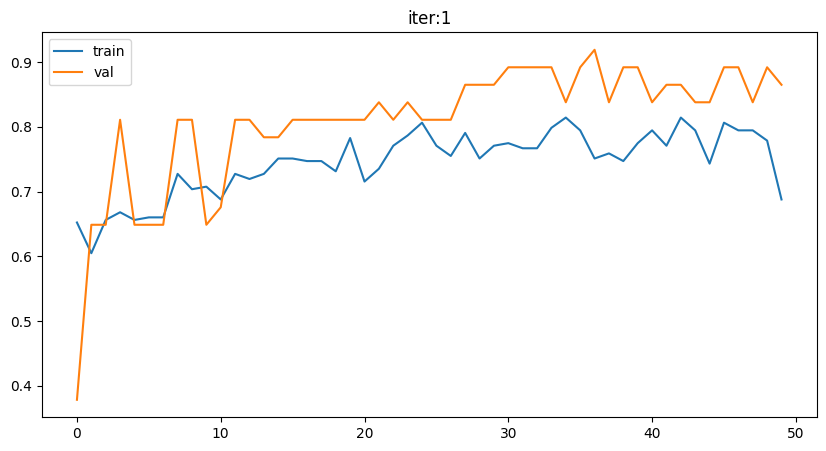

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

score = scores[scores['iter']==iter]
score_train = score[score['phase']=='train']
score_test = score[score['phase']=='val']
ax.plot(score_train['epoch'], score_train['acc'], label='train')
ax.plot(score_test['epoch'], score_test['acc'], label='val')
ax.set_title(f'iter:{iter}')
ax.legend()
plt.show(fig)

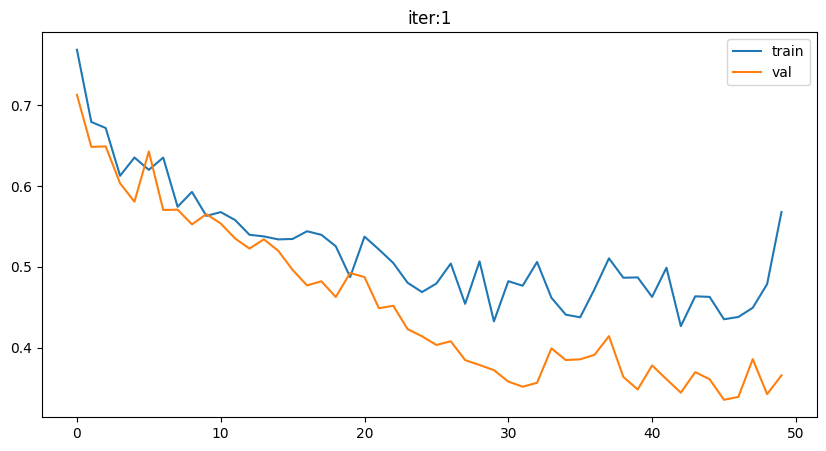

In [12]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
score = scores[scores['iter']==iter]
score_train = score[score['phase']=='train']
score_test = score[score['phase']=='val']
ax.plot(score_train['epoch'], score_train['loss'], label='train')
ax.plot(score_test['epoch'], score_test['loss'], label='val')
ax.set_title(f'iter:{iter}')
ax.legend()
plt.show(fig)

In [13]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{EPOCHS}_{iter}_best_loss_bin2.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,f'pred_test_swin_v2_b_best_loss_bin2_ep{EPOCHS}_{iter}.csv'), index=False)
test_df[f'pred_{iter}'] = pred_test

<ipython-input-13-603d07e8a629>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{E

In [14]:
from datetime import datetime

test_df['key'] = test_df['file_name'].apply(lambda x: os.path.basename(x))
test_df['predicted_label'] = pred_test
now = datetime.now()

# ファイル名と予測結果をDataFrameに変換
#判別結果をDataFrameに変換し、tsvファイルに出力
submit_file = f'/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver{now:%Y%m%d%H%M%S}.tsv'
print(submit_file)
test_df[['key','predicted_label']].to_csv(submit_file,
         index=False,
         header=False,
         sep='\t')

/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver20241002072028.tsv


In [15]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{EPOCHS}_{iter}_bin2.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,f'pred_test_swin_v2_b_bin2_ep{EPOCHS}_{iter}.csv'), index=False)
test_df[f'pred_{iter}'] = pred_test

<ipython-input-15-124b36e757c2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'swin_v2_b_seed{seed}_ep{E

In [16]:
from datetime import datetime

test_df['key'] = test_df['file_name'].apply(lambda x: os.path.basename(x))
test_df['predicted_label'] = pred_test

now = datetime.now()

# ファイル名と予測結果をDataFrameに変換
#判別結果をDataFrameに変換し、tsvファイルに出力
submit_file = f'/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver{now:%Y%m%d%H%M%S}.tsv'
print(submit_file)
test_df[['key','predicted_label']].to_csv(submit_file,
         index=False,
         header=False,
         sep='\t')

/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver20241002072057.tsv
